# Overview


- **2.0. Recap**
  - 2.0.1. *Perceptron*
  - 2.0.2. *Gradient Descent*
  - 2.0.3. *Training with PyTorch*
<br><br>

- **2.1. Autograd**
  - 2.1.1. *NN from Scratch*
  - 2.1.2. *Autograd with `loss.backward()`*
  - 2.1.3. *Forward propagation with `nn.Module`*
  - 2.1.4. *Parameter updates with `torch.optim`*
<br><br>

- **2.2. Activation Functions**
  - 2.2.1. *Sigmoid*
  - 2.2.2. *Other S-Shaped Activations*
  - 2.2.3. *More Activations*
  - 2.2.4. *Activation with PyTorch*
<br><br>

<!--
- **2.3. Loss Functions**
  - 2.3.1. *L1 Loss (MAE) and L2 Loss (MSE)*
  - 2.3.2. *Negative Log Likelihood* 
  - 2.3.3. *Cross-Entropy*
<br><br>

- **2.4. Optimizers**
  - 2.4.1. *Gradient Descent*
  - 2.4.2. *Stochastic Gradient Descent*
  - 2.4.3. *Adam*
  - 2.4.4. *Learning Rate Scheduler*
<br><br>
-->

In [1]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})

## 2.0.1.  Perceptron (Recap)


Given a set of inputs $x$, the perceptron 

 - learns $w$ tensor to map the inputs to a real-value output between $[0,1]$
 - through the summation of the dot product of the $w·x$ 
 - with a transformation function (aka. activation function), e.g. sigmoid function
 
 
### In Math:

$ \ \ \ \ \ \ \ \ \ sigmoid(s) = 1 / (1+e^{-s})$

$ \ \ \ \ \ \ \ \ \ perceptron(x) = sigmoid(\sum_{ 1 }^{ n }{w \cdot x})$

where $n$ is the no. of inputs.

### In Picture:

In [3]:
Image(url="https://ibin.co/4TyMU8AdpV4J.png", width=500)

(**Note:** Usually, we use $x_1$ as the bias and fix the input to 1)

# 2.0.2. Gradient Descent (Recap)

To learn the $w$ tensor, **gradient descent methods**, e.g. stochastic gradient descent (SGD) or SGD with momentum (Adam) is used to 

 - minimize the loss/difference between 
 - $y$: the desired truth value given the same $x$ inputs and 
 - $\hat{y}$: the output of the perceptron


#### Mean Absolute Loss (L1 Loss):

$ \ \ \ \ \ \ \ \ \ mae = \frac { 1 }{ m }  \sum_{ 1 }^{ m }{|y-\hat{y}|}$



#### Mean Square Loss (L2 Loss):

$ \ \ \ \ \ \ \ \ \ mse = \frac { 1 }{ m } \sum_{ 1 }^{ m }{(y-\hat{y})^2}$

where $m$ is the no. of predictions made by the perceptron.

# 2.0.3. Training Multi-Layered Perceptron with PyTorch

To train a model using PyTorch, we simply iterate through the no. of epochs and imperatively state the computations we want to perform. 

## Remember the steps?

 1. Initialize 
   - model and its layers, hidden dimensions and activation functions.
   - optimizers and its learning rate
   - loss function
   - stopping criteria
 2. Forward Propagation
 3. Backward Propagation
 4. Update Optimizer

In [4]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch import tensor
from torch import optim

import matplotlib.pyplot as plt

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# XOR gate inputs and outputs.
X = xor_input = tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = tensor([[0],[1],[1],[0]]).float().to(device)

# Use tensor.shape to get the shape of the matrix/tensor.
num_data, input_dim = X.shape
print('Inputs Dim:', input_dim) # i.e. n=2 

num_data, output_dim = Y.shape
print('Output Dim:', output_dim) 
print('No. of Data:', num_data) # i.e. n=4

Inputs Dim: 2
Output Dim: 1
No. of Data: 4


100%|██████████| 5000/5000 [00:01<00:00, 3168.66it/s]


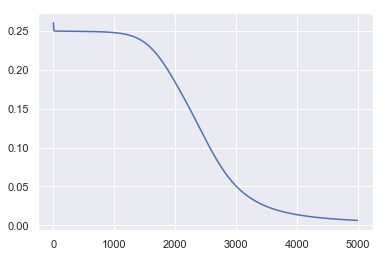

In [6]:
# Step 1: Initialization. 

# Initialize the model.
# Set the hidden dimension size.
hidden_dim = 10
# Use Sequential to define a simple feed-forward network.
model = nn.Sequential(
            # Use nn.Linear to get our simple perceptron.
            nn.Linear(input_dim, hidden_dim),
            # Use nn.Sigmoid to get our sigmoid non-linearity.
            nn.Sigmoid(),
            # Second layer neurons.
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

# Initialize the optimizer
learning_rate = 0.3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Initialize the loss function.
criterion = nn.MSELoss()

# Initialize the stopping criteria
# For simplicity, just stop training after certain no. of epochs.
num_epochs = 5000 

losses = [] # Keeps track of the loses.

# Step 2-4 of training routine.

for _e in tqdm(range(num_epochs)):
    # Reset the gradient after every epoch. 
    optimizer.zero_grad() 
    # Step 2: Foward Propagation
    predictions = model(X)
    
    # Step 3: Back Propagation 
    # Calculate the cost between the predictions and the truth.
    loss = criterion(predictions, Y)
    # Remember to back propagate the loss you've computed above.
    loss.backward()
    
    # Step 4: Optimizer take a step and update the weights.
    optimizer.step()
    
    # Log the loss value as we proceed through the epochs.
    losses.append(loss.data.item())
    

plt.plot(losses)

# 2.1. Autograd

In this section, we'll see how PyTorch does the `loss.backward()` and `optimizer.step()` behind the scenes.


## 2.1.1. NN from Scratch 

Before that lets relive the pains of coding neural nets from scratch (with `numpy`)...

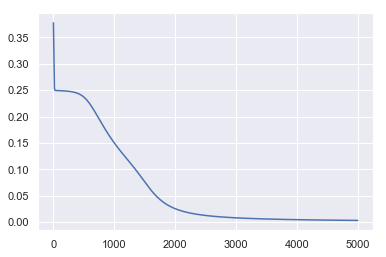

In [7]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

def sigmoid(x): # Returns values that sums to one.
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(sx):
    # See https://math.stackexchange.com/a/1225116
    return sx * (1 - sx)

# Cost functions.
def mse(predicted, truth):
    return np.square(predicted - truth).mean()

def mse_derivative(predicted, truth):
    # See https://math.stackexchange.com/a/1962938/34255
    return 2 * (predicted - truth)

X = xor_input = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = xor_output = np.array([[0,1,1,0]]).T

# Define the shape of the weight vector.
num_data, input_dim = X.shape
# Lets set the dimensions for the intermediate layer.
hidden_dim = 5
# Initialize weights between the input layers and the hidden layer.
W1 = np.random.random((input_dim, hidden_dim))

# Define the shape of the output vector. 
output_dim = len(Y.T)
# Initialize weights between the hidden layers and the output layer.
W2 = np.random.random((hidden_dim, output_dim))

# Initialize weigh
num_epochs = 5000
learning_rate = 0.15

losses = []

for epoch_n in range(num_epochs):
    layer0 = X
    # Forward propagation.
    
    # Inside the perceptron, Step 2. 
    layer1 = sigmoid(np.dot(layer0, W1))
    layer2 = sigmoid(np.dot(layer1, W2))

    # Back propagation (Y -> layer2)
    # How much did we miss in the predictions?
    cost_error = mse(layer2, Y)
    
    # In what direction is the target value?
    # Were we really close? If so, don't change too much.
    layer2_error = mse_derivative(layer2, Y)
    layer2_delta = layer2_error *  sigmoid_derivative(layer2)
    
    # Back propagation (layer2 -> layer1)
    # How much did each layer1 value contribute to the layer2 error (according to the weights)?
    layer1_error = np.dot(layer2_delta, W2.T)
    layer1_delta = layer1_error * sigmoid_derivative(layer1)
    
    # update weights
    W2 += - learning_rate * np.dot(layer1.T, layer2_delta)
    W1 += - learning_rate * np.dot(layer0.T, layer1_delta)
    #print(np.dot(layer0.T, layer1_delta))
    #print(epoch_n, list((layer2)))
    
    # Log the loss value as we proceed through the epochs.
    losses.append(cost_error)
    #print(cost_delta)

    
# Visualize the losses
plt.plot(losses)
plt.show()

## 2.1.2. Autograd with `loss.backward()`

The nice thing about the `loss.backward()` function is that it does automatic gradient backpropagation and **we don't have to go through the multiple dot products on layer errors and deltas** =)

To do so lets use

 - `torch.tensor()` objects to initialize X and Y.
 - `torch.randn()` objects to initialize the W1 and W2
 - `torch.exp` and `torch.mean` to replace the numpy functions.


  1%|          | 99/10000 [00:00<00:21, 460.06it/s]

epoch: 0 W1.grad: None
epoch: 1 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 10 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 11 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 12 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 13 W1.grad: tensor(

  2%|▏         | 210/10000 [00:00<00:19, 503.73it/s]

epoch: 99 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 100 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 101 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 102 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 103 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 104 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 105 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 106 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 107 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 108 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 109 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 110 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 111 W1.grad: tensor([[

  3%|▎         | 329/10000 [00:00<00:17, 544.98it/s]

epoch: 210 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 211 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 212 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 213 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 214 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 215 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 216 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 217 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 218 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 219 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 220 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 221 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 222 W1.grad: tensor([

  4%|▍         | 380/10000 [00:00<00:19, 482.02it/s]

epoch: 329 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 330 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 331 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 332 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 333 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 334 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 335 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 336 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 337 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 338 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 339 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 340 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 341 W1.grad: tensor([

  5%|▍         | 494/10000 [00:00<00:19, 494.51it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 402 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 403 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 404 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 405 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 406 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 407 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 408 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 409 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 410 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 411 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 412 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 413 W1.grad: tensor([[0., 0., 0., 0., 0.]

  6%|▌         | 608/10000 [00:01<00:17, 528.09it/s]

epoch: 520 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 521 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 522 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 523 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 524 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 525 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 526 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 527 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 528 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 529 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 530 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 531 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 532 W1.grad: tensor([

  7%|▋         | 716/10000 [00:01<00:17, 528.88it/s]

epoch: 631 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 632 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 633 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 634 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 635 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 636 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 637 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 638 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 639 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 640 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 641 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 642 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 643 W1.grad: tensor([

  8%|▊         | 824/10000 [00:01<00:18, 502.06it/s]

epoch: 735 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 736 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 737 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 738 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 739 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 740 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 741 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 742 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 743 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 744 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 745 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 746 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 747 W1.grad: tensor([

  9%|▉         | 875/10000 [00:01<00:19, 478.02it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 831 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 832 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 833 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 834 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 835 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 836 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 837 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 838 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 839 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 840 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 841 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 842 W1.grad: tensor([[0., 0., 0., 0., 0.]

 10%|▉         | 979/10000 [00:01<00:18, 481.77it/s]

epoch: 929 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 930 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 931 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 932 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 933 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 934 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 935 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 936 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 937 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 938 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 939 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 940 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 941 W1.grad: tensor([

 11%|█         | 1081/10000 [00:02<00:19, 450.87it/s]

epoch: 1030 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1031 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1032 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1033 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1034 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1035 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1036 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1037 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1038 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1039 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1040 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1041 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1042 W1.g

 12%|█▏        | 1194/10000 [00:02<00:17, 499.55it/s]

epoch: 1121 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1122 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1123 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1124 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1125 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1126 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1127 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1128 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1129 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1130 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1131 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1132 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1133 W1.g

 13%|█▎        | 1321/10000 [00:02<00:15, 558.81it/s]

epoch: 1237 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1238 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1239 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1240 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1241 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1242 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1243 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1244 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1245 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1246 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1247 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1248 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1249 W1.g

 14%|█▍        | 1436/10000 [00:02<00:16, 511.67it/s]

epoch: 1360 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1361 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1362 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1363 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1364 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1365 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1366 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1367 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1368 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1369 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1370 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1371 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1372 W1.g

 15%|█▍        | 1489/10000 [00:02<00:18, 467.15it/s]

epoch: 1445 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1446 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1447 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1448 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1449 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1450 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1451 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1452 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1453 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1454 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1455 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1456 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1457 W1.g

 16%|█▌        | 1584/10000 [00:03<00:20, 413.53it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1527 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1528 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1529 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1530 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1531 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1532 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1533 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1534 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1535 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1536 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1537 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1538 W1.grad: tensor([[0., 0.,

 17%|█▋        | 1674/10000 [00:03<00:19, 424.59it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1601 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1602 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1603 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1604 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1605 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1606 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1607 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1608 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1609 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1610 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1611 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1612 W1.grad: tensor([[0., 0.,

 18%|█▊        | 1763/10000 [00:03<00:19, 413.68it/s]

epoch: 1687 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1688 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1689 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1690 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1691 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1692 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1693 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1694 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1695 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1696 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1697 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1698 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1699 W1.g

 18%|█▊        | 1806/10000 [00:03<00:20, 394.53it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1770 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1771 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1772 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1773 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1774 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1775 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1776 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1777 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1778 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1779 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1780 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1781 W1.grad: tensor([[0., 0.,

 19%|█▉        | 1888/10000 [00:03<00:20, 398.29it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1846 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1847 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1848 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1849 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1850 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1851 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1852 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1853 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1854 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1855 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1856 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1857 W1.grad: tensor([[0., 0.,

 20%|█▉        | 1974/10000 [00:04<00:20, 399.33it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1930 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1931 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1932 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1933 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1934 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1935 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1936 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1937 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1938 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1939 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1940 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 1941 W1.grad: tensor([[0., 0.,

 21%|██        | 2054/10000 [00:04<00:21, 375.49it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2005 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2006 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2007 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2008 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2009 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2010 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2011 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2012 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2013 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2014 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2015 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2016 W1.grad: tensor([[0., 0.,

 21%|██▏       | 2129/10000 [00:04<00:23, 334.51it/s]

epoch: 2071 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2072 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2073 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2074 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2075 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2076 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2077 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2078 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2079 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2080 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2081 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2082 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2083 W1.g

 22%|██▏       | 2215/10000 [00:04<00:20, 376.57it/s]

epoch: 2136 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2137 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2138 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2139 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2140 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2141 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2142 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2143 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2144 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2145 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2146 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2147 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2148 W1.g

 23%|██▎       | 2343/10000 [00:05<00:16, 476.86it/s]

epoch: 2225 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2226 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2227 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2228 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2229 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2230 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2231 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2232 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2233 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2234 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2235 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2236 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2237 W1.g

 25%|██▍       | 2469/10000 [00:05<00:13, 545.13it/s]

epoch: 2353 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2354 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2355 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2356 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2357 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2358 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2359 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2360 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2361 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2362 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2363 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2364 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2365 W1.g

 26%|██▌       | 2585/10000 [00:05<00:13, 529.92it/s]

epoch: 2479 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2480 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2481 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2482 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2483 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2484 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2485 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2486 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2487 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2488 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2489 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2490 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2491 W1.g

 26%|██▋       | 2640/10000 [00:05<00:14, 502.13it/s]

epoch: 2585 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2586 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2587 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2588 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2589 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2590 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2591 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2592 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2593 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2594 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2595 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2596 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2597 W1.g

 28%|██▊       | 2760/10000 [00:05<00:13, 545.84it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2688 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2689 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2690 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2691 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2692 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2693 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2694 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2695 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2696 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2697 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2698 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2699 W1.grad: tensor([[0., 0.,

 29%|██▉       | 2890/10000 [00:05<00:11, 593.02it/s]

epoch: 2815 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2816 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2817 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2818 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2819 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2820 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2821 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2822 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2823 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2824 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2825 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2826 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2827 W1.g

 30%|███       | 3024/10000 [00:06<00:11, 618.97it/s]

epoch: 2949 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2950 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2951 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2952 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2953 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2954 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2955 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2956 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2957 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2958 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2959 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2960 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 2961 W1.g

 32%|███▏      | 3156/10000 [00:06<00:10, 625.75it/s]

epoch: 3079 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3080 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3081 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3082 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3083 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3084 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3085 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3086 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3087 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3088 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3089 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3090 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3091 W1.g

 33%|███▎      | 3288/10000 [00:06<00:10, 637.70it/s]

epoch: 3204 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3205 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3206 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3207 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3208 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3209 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3210 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3211 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3212 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3213 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3214 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3215 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3216 W1.g

 34%|███▍      | 3421/10000 [00:06<00:10, 607.45it/s]

epoch: 3321 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3322 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3323 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3324 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3325 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3326 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3327 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3328 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3329 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3330 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3331 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3332 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3333 W1.g

 36%|███▌      | 3555/10000 [00:07<00:10, 633.73it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3441 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3442 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3443 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3444 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3445 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3446 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3447 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3448 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3449 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3450 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3451 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3452 W1.grad: tensor([[0., 0.,

 37%|███▋      | 3690/10000 [00:07<00:09, 644.49it/s]

epoch: 3572 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3573 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3574 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3575 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3576 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3577 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3578 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3579 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3580 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3581 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3582 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3583 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3584 W1.g

 38%|███▊      | 3827/10000 [00:07<00:09, 653.62it/s]

epoch: 3703 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3704 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3705 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3706 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3707 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3708 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3709 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3710 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3711 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3712 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3713 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3714 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3715 W1.g

 40%|███▉      | 3962/10000 [00:07<00:09, 656.05it/s]

epoch: 3835 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3836 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3837 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3838 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3839 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3840 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3841 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3842 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3843 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3844 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3845 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3846 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3847 W1.g

 41%|████      | 4099/10000 [00:07<00:08, 656.69it/s]

epoch: 3968 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3969 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3970 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3971 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3972 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3973 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3974 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3975 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3976 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3977 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3978 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3979 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 3980 W1.g

 42%|████▏     | 4237/10000 [00:08<00:08, 664.91it/s]

epoch: 4102 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4103 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4104 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4105 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4106 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4107 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4108 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4109 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4110 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4111 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4112 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4113 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4114 W1.g

 43%|████▎     | 4304/10000 [00:08<00:08, 645.72it/s]

epoch: 4237 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4238 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4239 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4240 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4241 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4242 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4243 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4244 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4245 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4246 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4247 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4248 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4249 W1.g

 44%|████▍     | 4438/10000 [00:08<00:08, 635.01it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4368 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4369 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4370 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4371 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4372 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4373 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4374 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4375 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4376 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4377 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4378 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4379 W1.grad: tensor([[0., 0.,

 46%|████▌     | 4573/10000 [00:08<00:08, 648.19it/s]

epoch: 4495 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4496 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4497 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4498 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4499 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4500 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4501 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4502 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4503 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4504 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4505 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4506 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4507 W1.g

 47%|████▋     | 4705/10000 [00:08<00:08, 644.88it/s]

epoch: 4627 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4628 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4629 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4630 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4631 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4632 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4633 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4634 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4635 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4636 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4637 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4638 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4639 W1.g

 48%|████▊     | 4840/10000 [00:09<00:07, 655.48it/s]

epoch: 4756 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4757 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4758 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4759 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4760 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4761 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4762 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4763 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4764 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4765 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4766 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4767 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4768 W1.g

 50%|████▉     | 4972/10000 [00:09<00:07, 651.39it/s]

epoch: 4889 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4890 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4891 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4892 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4893 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4894 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4895 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4896 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4897 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4898 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4899 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4900 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 4901 W1.g

 51%|█████     | 5106/10000 [00:09<00:07, 648.01it/s]

epoch: 5017 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5018 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5019 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5020 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5021 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5022 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5023 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5024 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5025 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5026 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5027 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5028 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5029 W1.g

 52%|█████▏    | 5240/10000 [00:09<00:07, 653.72it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5148 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5149 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5150 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5151 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5152 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5153 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5154 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5155 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5156 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5157 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5158 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5159 W1.grad: tensor([[0., 0.,

 54%|█████▍    | 5375/10000 [00:09<00:07, 654.47it/s]

epoch: 5278 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5279 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5280 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5281 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5282 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5283 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5284 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5285 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5286 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5287 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5288 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5289 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5290 W1.g

 55%|█████▌    | 5512/10000 [00:10<00:06, 661.08it/s]

epoch: 5408 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5409 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5410 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5411 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5412 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5413 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5414 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5415 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5416 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5417 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5418 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5419 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5420 W1.g

 56%|█████▋    | 5648/10000 [00:10<00:06, 656.55it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5540 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5541 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5542 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5543 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5544 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5545 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5546 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5547 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5548 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5549 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5550 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5551 W1.grad: tensor([[0., 0.,

 58%|█████▊    | 5786/10000 [00:10<00:06, 651.86it/s]

epoch: 5667 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5668 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5669 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5670 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5671 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5672 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5673 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5674 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5675 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5676 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5677 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5678 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5679 W1.g

 59%|█████▉    | 5921/10000 [00:10<00:06, 652.12it/s]

epoch: 5797 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5798 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5799 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5800 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5801 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5802 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5803 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5804 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5805 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5806 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5807 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5808 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5809 W1.g

 61%|██████    | 6057/10000 [00:10<00:06, 651.85it/s]


epoch: 5928 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5929 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5930 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5931 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5932 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5933 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5934 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5935 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5936 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5937 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5938 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5939 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 5940 W1.

 61%|██████    | 6123/10000 [00:10<00:06, 634.78it/s]


epoch: 6061 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6062 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6063 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6064 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6065 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6066 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6067 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6068 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6069 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6070 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6071 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6072 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6073 W1.

 63%|██████▎   | 6261/10000 [00:11<00:05, 639.76it/s]

epoch: 6194 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6195 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6196 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6197 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6198 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6199 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6200 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6201 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6202 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6203 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6204 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6205 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6206 W1.g

 64%|██████▍   | 6393/10000 [00:11<00:05, 638.65it/s]

epoch: 6322 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6323 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6324 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6325 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6326 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6327 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6328 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6329 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6330 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6331 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6332 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6333 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6334 W1.g

 65%|██████▌   | 6525/10000 [00:11<00:05, 582.96it/s]

epoch: 6452 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6453 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6454 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6455 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6456 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6457 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6458 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6459 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6460 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6461 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6462 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6463 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6464 W1.g

 67%|██████▋   | 6661/10000 [00:11<00:05, 572.12it/s]

epoch: 6554 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6555 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6556 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6557 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6558 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6559 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6560 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6561 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6562 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6563 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6564 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6565 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6566 W1.g

 68%|██████▊   | 6790/10000 [00:12<00:05, 589.35it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6673 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6674 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6675 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6676 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6677 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6678 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6679 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6680 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6681 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6682 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6683 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6684 W1.grad: tensor([[0., 0.,

 69%|██████▉   | 6911/10000 [00:12<00:05, 584.14it/s]

 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6799 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6800 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6801 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6802 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6803 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6804 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6805 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6806 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6807 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6808 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6809 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6810 W1.grad: tensor([[0., 0.

 70%|███████   | 7034/10000 [00:12<00:04, 595.44it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6915 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6916 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6917 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6918 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6919 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6920 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6921 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6922 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6923 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6924 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6925 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 6926 W1.grad: tensor([[0., 0.,

 72%|███████▏  | 7166/10000 [00:12<00:04, 624.18it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7038 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7039 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7040 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7041 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7042 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7043 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7044 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7045 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7046 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7047 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7048 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7049 W1.grad: tensor([[0., 0.,

 72%|███████▏  | 7230/10000 [00:12<00:04, 615.04it/s]

epoch: 7168 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7169 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7170 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7171 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7172 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7173 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7174 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7175 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7176 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7177 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7178 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7179 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7180 W1.g

 74%|███████▎  | 7363/10000 [00:13<00:04, 639.37it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7295 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7296 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7297 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7298 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7299 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7300 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7301 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7302 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7303 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7304 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7305 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7306 W1.grad: tensor([[0., 0.,

 75%|███████▌  | 7503/10000 [00:13<00:03, 648.05it/s]

epoch: 7435 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7436 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7437 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7438 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7439 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7440 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7441 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7442 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7443 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7444 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7445 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7446 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7447 W1.g

 76%|███████▋  | 7637/10000 [00:13<00:03, 643.43it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7566 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7567 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7568 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7569 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7570 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7571 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7572 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7573 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7574 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7575 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7576 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7577 W1.grad: tensor([[0., 0.,

 78%|███████▊  | 7771/10000 [00:13<00:03, 643.31it/s]

epoch: 7696 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7697 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7698 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7699 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7700 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7701 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7702 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7703 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7704 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7705 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7706 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7707 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7708 W1.g

 79%|███████▉  | 7906/10000 [00:13<00:03, 590.43it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7827 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7828 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7829 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7830 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7831 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7832 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7833 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7834 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7835 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7836 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7837 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7838 W1.grad: tensor([[0., 0.,

 80%|████████  | 8037/10000 [00:14<00:03, 598.06it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7925 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7926 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7927 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7928 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7929 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7930 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7931 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7932 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7933 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7934 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7935 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 7936 W1.grad: tensor([[0., 0.,

 82%|████████▏ | 8167/10000 [00:14<00:02, 618.16it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8048 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8049 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8050 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8051 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8052 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8053 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8054 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8055 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8056 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8057 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8058 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8059 W1.grad: tensor([[0., 0.,

 83%|████████▎ | 8295/10000 [00:14<00:02, 617.70it/s]

epoch: 8175 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8176 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8177 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8178 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8179 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8180 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8181 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8182 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8183 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8184 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8185 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8186 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8187 W1.g

 84%|████████▎ | 8358/10000 [00:14<00:02, 598.15it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8301 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8302 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8303 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8304 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8305 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8306 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8307 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8308 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8309 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8310 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8311 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8312 W1.grad: tensor([[0., 0.,

 85%|████████▍ | 8490/10000 [00:14<00:02, 619.88it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8426 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8427 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8428 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8429 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8430 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8431 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8432 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8433 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8434 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8435 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8436 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8437 W1.grad: tensor([[0., 0.,

 86%|████████▋ | 8626/10000 [00:15<00:02, 642.38it/s]

epoch: 8559 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8560 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8561 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8562 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8563 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8564 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8565 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8566 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8567 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8568 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8569 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8570 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8571 W1.g

 88%|████████▊ | 8764/10000 [00:15<00:01, 643.51it/s]

epoch: 8695 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8696 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8697 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8698 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8699 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8700 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8701 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8702 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8703 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8704 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8705 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8706 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8707 W1.g

 89%|████████▉ | 8900/10000 [00:15<00:01, 658.94it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8824 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8825 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8826 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8827 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8828 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8829 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8830 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8831 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8832 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8833 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8834 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8835 W1.grad: tensor([[0., 0.,

 90%|█████████ | 9035/10000 [00:15<00:01, 643.21it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8960 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8961 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8962 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8963 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8964 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8965 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8966 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8967 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8968 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8969 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8970 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 8971 W1.grad: tensor([[0., 0.,

 92%|█████████▏| 9168/10000 [00:15<00:01, 651.36it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9086 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9087 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9088 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9089 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9090 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9091 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9092 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9093 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9094 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9095 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9096 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9097 W1.grad: tensor([[0., 0.,

 93%|█████████▎| 9302/10000 [00:16<00:01, 659.48it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9218 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9219 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9220 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9221 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9222 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9223 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9224 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9225 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9226 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9227 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9228 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9229 W1.grad: tensor([[0., 0.,

 94%|█████████▍| 9435/10000 [00:16<00:00, 651.58it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9352 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9353 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9354 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9355 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9356 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9357 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9358 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9359 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9360 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9361 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9362 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9363 W1.grad: tensor([[0., 0.,

 96%|█████████▌| 9570/10000 [00:16<00:00, 649.71it/s]

epoch: 9476 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9477 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9478 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9479 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9480 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9481 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9482 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9483 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9484 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9485 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9486 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9487 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9488 W1.g

 97%|█████████▋| 9707/10000 [00:16<00:00, 656.93it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9608 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9609 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9610 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9611 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9612 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9613 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9614 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9615 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9616 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9617 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9618 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9619 W1.grad: tensor([[0., 0.,

 98%|█████████▊| 9843/10000 [00:16<00:00, 658.12it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9740 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9741 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9742 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9743 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9744 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9745 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9746 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9747 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9748 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9749 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9750 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9751 W1.grad: tensor([[0., 0.,

100%|██████████| 10000/10000 [00:17<00:00, 583.23it/s]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9869 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9870 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9871 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9872 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9873 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9874 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9875 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9876 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9877 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9878 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9879 W1.grad: tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
epoch: 9880 W1.grad: tensor([[0., 0.,

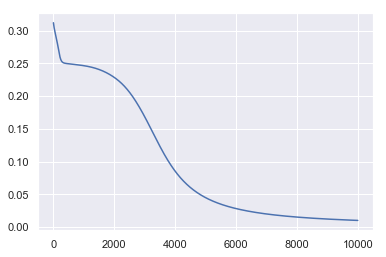

In [10]:
def sigmoid(x): # Returns values that sums to one.
    return 1 / (1 + torch.exp(-x))

# Cost functions.
def mse(predicted, truth):
    return torch.mean((predicted - truth)**2)

X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

# Define the shape of the weight vector.
num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)
# When we initialize tensors that needs updating, we use `require_grad=True` 
# for autograd to kick in later on.
W1 = torch.randn(input_dim, hidden_dim, requires_grad=True).to(device)
W2 = torch.randn(hidden_dim, output_dim, requires_grad=True).to(device)


num_epochs = 10000
learning_rate = 0.3

losses = []

for epoch_n in tqdm(range(num_epochs)):
    layer0 = X
    # See https://pytorch.org/docs/stable/torch.html#torch.mm
    # Use the torch.tensor.mm() instead of np.dot()
    layer1 = sigmoid(X.mm(W1))
    layer2 = sigmoid(layer1.mm(W2))

    # Loss is a Tensor of torch.Size([]), so and loss.item() is a scalar/float.
    # Try printing `print(loss.shape)` to confirm the above.
    loss = mse(layer2, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # The `loss.backward()` will compute the gradient of loss w.r.t. all
    # tensors that has `requires_grad=True`.
    # After this, W1.grad and W2.grad will hold the gradients of 
    # the loss w.r.t. to W1 and W2 respectively.
    print("epoch:", epoch_n, "W1.grad:", W1.grad)
    loss.backward()
    
    # Now we have the backpropagated gradients, we want to update the weights.
    # Whenever you perform tensor operations on tensors that has `requires_grad=True`,
    # pytorch will try to build computation graph. For now, we only need to 
    # force the updates of our weights without forming more computation graph,
    # so we use the no_grad() context manager:
    with torch.no_grad():
        W1 += -learning_rate * W1.grad
        W2 += -learning_rate * W2.grad
        
    # Manually zero the gradients after running the backward pass.
    # Every epoch our graphs needs to be re-computed. 
    W1.grad.zero_()
    W2.grad.zero_()

# Visualize the losses
plt.plot(losses)
plt.show()

### Play around with the code above

 - See what's the gradient values after `loss.backward()`, **print out `W1.grad` and `W2.grad`** 
 <br><br>
 - Check **what happens when you don't have `torch.no_grad()`** context manager, (hint: pytorch will complain)
 <br><br>
 - **What happens when you don't zero the gradients?** How will it affect the loss? 
 <br><br>
 - Note that in both the sigmoid and the MSE function, **we didn't declare any derivatives** 
   - the `torch.autograd` module has helped do the grunt work of computing backpropagation
   - It's out of scope for this course to create custom `backward()` autograd function, but I'll leave you with [this tutorial](https://github.com/jcjohnson/pytorch-examples#pytorch-defining-new-autograd-functions)
 

## 2.1.3. Forward Propagation with `nn.Module`

Now that we know how the backpropagation is automated with autograd, we should have similar mechanism when we declare a complicated neural network and forward propagate too. The `nn` package in PyTorch serves this purpose.

An `nn.Module` receive input tensors and compute the output tensor. Depending on the `nn.Module` type, it might also hold learnable weights/parameters tensors.

Previously we were declaring the network and initialize the learnable weights/parameters in a raw manner:

```python
X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)

W1 = torch.randn(input_dim, hidden_dim, requires_grad=True).to(device)
W2 = torch.randn(hidden_dim, output_dim, requires_grad=True).to(device)
```

Then we had to apply the layers and activation manually during the training routine:

```python
for epoch_n in tqdm(range(num_epochs)):
    layer0 = X
    layer1 = sigmoid(X.mm(W1))
    layer2 = sigmoid(layer1.mm(W2))

```

Instead of doing that we can define our model as a sequence of layers with `nn.Sequential(...)`, e.g. 

```python

model = torch.nn.Sequential(
          torch.nn.Linear(input_dim, hidden_dim),
          torch.nn.Sigmoid(),
          torch.nn.Linear(hidden_dim, output_dim),
          torch.nn.Sigmoid()
        )

```

And even the loss function can be a `nn.Module`, e.g. 

```python
criterion = nn.MSELoss()
```

And forward propagation would be simply this:


100%|██████████| 10000/10000 [00:05<00:00, 1965.81it/s]


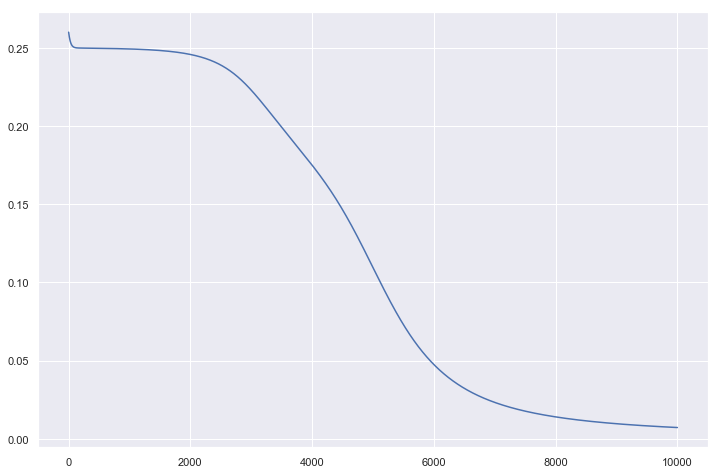

In [382]:
X = xor_input = torch.tensor([[0,0], [0,1], [1,0], [1,1]]).float().to(device)
Y = xor_output = torch.tensor([[0], [1], [1], [0]]).float().to(device)

# Define the shape of the weight vector.
num_data, input_dim = X.shape
hidden_dim = 5
output_dim = len(Y)

# Initialize the network as an nn.Sequential.
model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.Sigmoid(),
          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
        ).to(device)

# Declare the loss function as an nn.Module.
criterion = nn.MSELoss()

num_epochs = 10000
learning_rate = 0.3

losses = []

for epoch_n in tqdm(range(num_epochs)):
    # Forward propagation.
    predictions = model(X)
    # Compute Loss
    loss = criterion(predictions, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # Backpropagation.
    loss.backward()
    
    # Instead of manually coding which weight tensors to update,
    # we iterate through all the layers in the model, and update 
    # the parameters by access the backpropdated gradients respectively.
    with torch.no_grad():
        for param in model.???():
            # Remember each parameter keeps their own .grad tensors after loss.backward()
            param.data += -??? * param.???
        
    # Zero the gradients after running the backward pass, 
    # the nn.Sequential will automatically go to each learnable parameter
    # to zero its gradient.
    model.???()

# Visualize the losses
plt.plot(losses)
plt.show()

## 2.1.4. Parameter updates with `torch.optim`

Updating the weights is the last step to automating the backpropagation and weights updates. For this, the `torch.optim` package handles the learning rate updates that we've been doing manually, i.e. 

```python
with torch.no_grad():
    for param in model.parameters():
        param.data += -learning_rate * param.grad
```

We use the objects in the `torch.optim` module to initialize the optimizer objects that will help hold the gradients updates according to the `model.parameters()` it's initialized with. E.g. 


100%|██████████| 10000/10000 [00:03<00:00, 2539.97it/s]


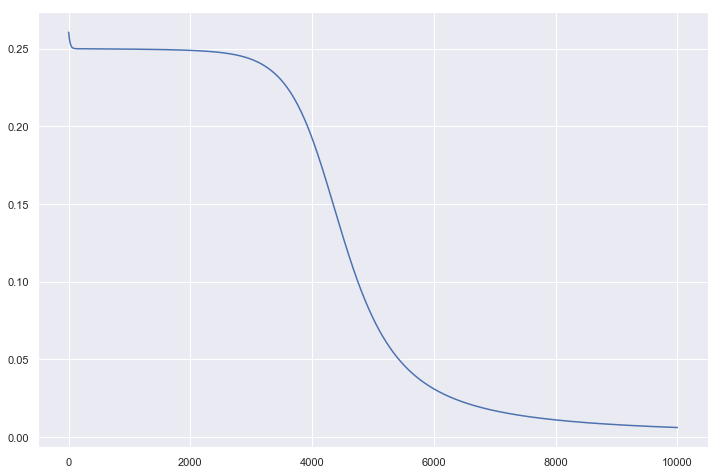

In [383]:
# Initialize the network as an nn.Sequential.
model = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.Sigmoid(),
          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
        ).to(device)

# Declare the loss function as an nn.Module.
criterion = nn.MSELoss()

num_epochs = 10000
learning_rate = 0.3

# Initialize the optimizer that'll help us with the parameters updates.
optimizer = torch.optim.SGD(model.???(), lr=learning_rate)

losses = []

for epoch_n in tqdm(range(num_epochs)):
    # When we move on in this epoch, we should forget the .grad tensors
    # in the previous epoch since we already made the updates. 
    optimizer.???()
    
    # Forward propagation.
    predictions = model(X)
    # Compute Loss
    loss = criterion(???, Y)
    # Keep track of the losses.
    losses.append(loss.item())
    
    # Backpropagation.
    loss.???()
    
    # The step() function will update the parameters in the models that 
    # has the .grad tensors respectively.
    optimizer.???()


# Visualize the losses
plt.plot(losses)
plt.show()

# 2.2. Activation Functions

They are the transformation functions within the perceptrons. 


## 2.2.1 Sigmoid

Previously we have seen the S-shaped ***sigmoid*** function:

$\large \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}$


The main properties of the ***sigmoid*** are:

 - "squeezes" into to a range between (0,1)
 - use as activation function for neural nets
 - use for binary classification in logistic regression 


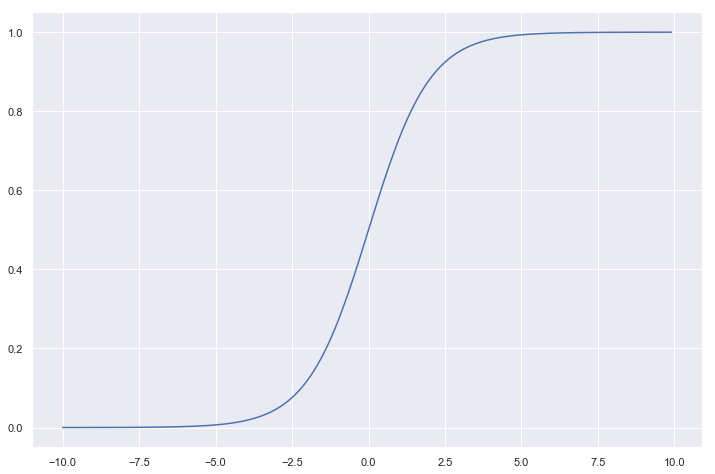

In [386]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def sigmoid_derivative(sx):
    # sx = sigmoid(x)
    return sx * (1 - sx)

x = np.arange(-10, 10, 0.1)
y = sigmoid(x)

plt.plot(x,y)
plt.show()

## 2.2.2. Other S-Shaped Activations

There are other S-shaped activation functions that shares similar properties as the ***sigmoid***, e.g.

<!--
$\large \tanh(x) = \frac{e^x - e^{-x}} {e^x + e^{-x}}$
-->


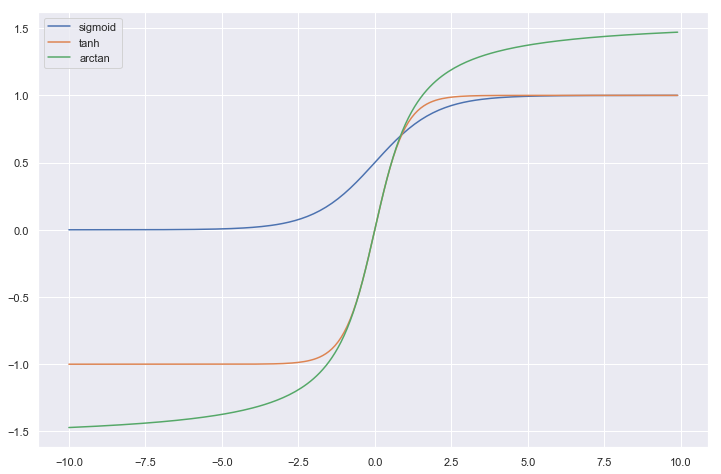

In [167]:
def tanh(x):
    # https://www.numpy.org/devdocs/reference/generated/numpy.tanh.html
    return np.tanh(x)

def arctan(x):
    # https://www.numpy.org/devdocs/reference/generated/numpy.arctan.html 
    return np.arctan(x)

x = np.arange(-10, 10, 0.1)
y1 = sigmoid(x)
y2 = tanh(x)
y3 = arctan(x)


plt.plot(x,y1, label='sigmoid')
plt.plot(x,y2, label='tanh')
plt.plot(x,y3, label='arctan')
plt.legend(loc='upper left')
plt.show()

## 2.2.3. More Activations

***Softmax*** is an activation is used quite a lot in NLP. 

$\Large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

Because it has the special properties of ***changing values in a 1-D vector to a probabilistic interpretation***, <br>i.e. the **sum of the softmax output sums to 1.0**.


In [168]:
def softmax(x):
    return ???

x = np.arange(-10, 10, 0.1)
y1 = softmax(x)
#y2 = relu(x)

print('Sum of softmax(x) =', y1.sum())

Sum of softmax(x) = 1.0


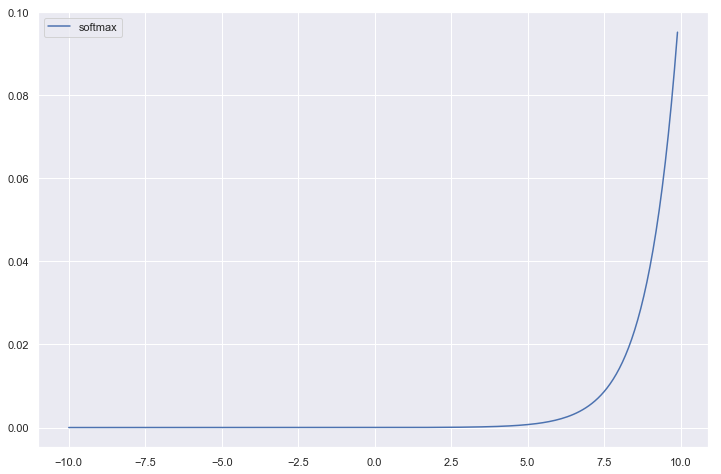

In [169]:
plt.plot(x,y1, label='softmax')
plt.legend(loc='upper left')
plt.show()

***Rectified Linear Unit (ReLU)*** is another common activation function , it simply checks whether the input is more than zero element-wise, if input is sub-zero, the ReLU output is clipped at zero:

$\large \text{ReLU}(x)= \max(0, x)$



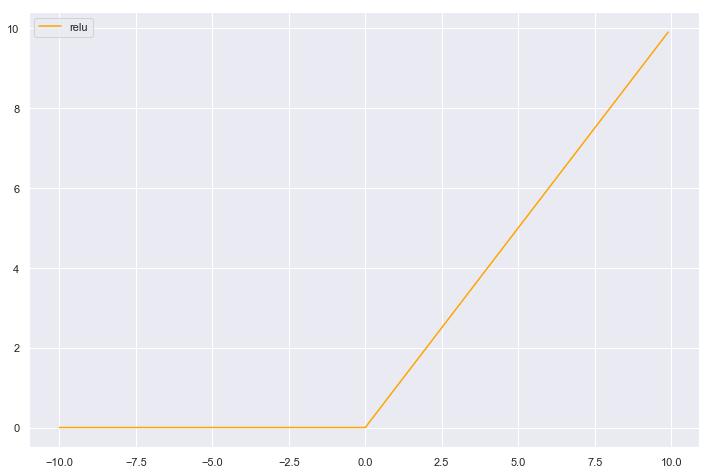

In [170]:
def relu(x):
    return x * (x > 0)

y2 = relu(x)

plt.plot(x,y2, label='relu', color='orange')
plt.legend(loc='upper left')
plt.show()

**Scaled Exponential Linear Units** is one of the many latest activation kid on the block. It's suppose to impose ***self-normalizing properties*** to the neural nets such that the training is more stable for deeper networks.

$\text{SELU}(x) = \text{scale} * (\max(0,x) + \min(0, \alpha * (\exp(x) - 1)))$

where, 

$\alpha = 1.6732632423543772848170429916717$ and <br>
$\text{scale} = 1.0507009873554804934193349852946$

On [paper](https://arxiv.org/pdf/1706.02515.pdf) (Klambauer et al. 2017) showed that it outperforms many other regularization/normalization tricks. 

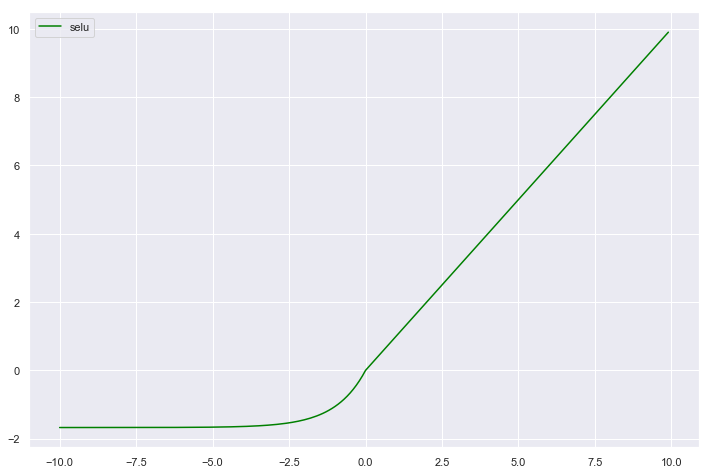

In [171]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return (np.maximum(???) + np.minimum(???))

y3 = selu(x)

plt.plot(x,y3, label='selu', color='green')
plt.legend(loc='upper left')
plt.show()

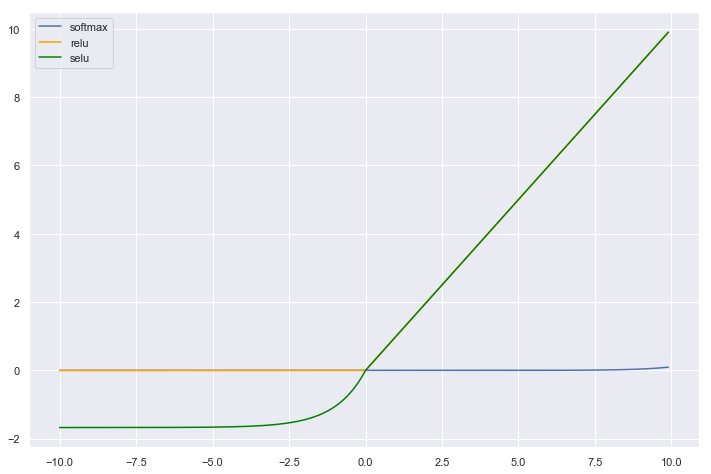

In [172]:
x = np.arange(-10, 10, 0.1)

y1 = softmax(x)
y2 = relu(x)
y3 = selu(x)

plt.plot(x,y1, label='softmax')
plt.plot(x,y2, label='relu', color='orange')
plt.plot(x,y3, label='selu', color='green')
plt.legend(loc='upper left')
plt.show()

## 2.2.4. Activation with PyTorch

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


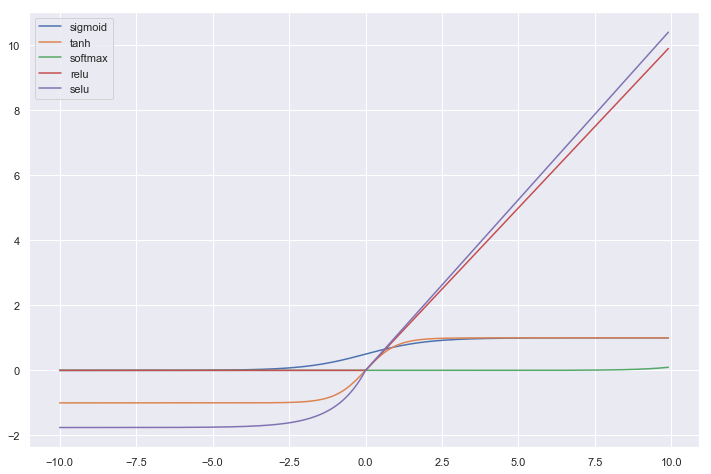

In [173]:
import torch
from torch import nn

x = torch.tensor(np.arange(-10, 10, 0.1))

# See https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity 
a1 = nn.Sigmoid()
a2 = nn.???()    # Fill in the tanh function.
a3 = nn.???() # Fill in the softmax function.
a4 = nn.???()    # Fill-in the relu func.
a5 = nn.???()    # Fill in the selu func.

# pyplot only accepts numpy arrays...
# Pardon the laziness
y1 = a1(x).numpy() 
y2 = a2(x).numpy() 
y3 = a3(x).numpy() 
y4 = a4(x).numpy() 
y5 = a5(x).numpy()
x = x.numpy()

plt.plot(x,y1, label='sigmoid')
plt.plot(x,y2, label='tanh')
plt.plot(x,y3, label='softmax')
plt.plot(x,y4, label='relu')
plt.plot(x,y5, label='selu')
plt.legend(loc='upper left')
plt.show()